# Efficient Reinforcement Learning
So far, supervised learning (SML) tasks were considered, where an algorithm was expected to learn the relationship $f: \mathbb{R}^{n_i} : \mathbb{R}^{n_o}$ using a labeled dataset $\mathbb{D} := \{ (x_j, y_j), j\in [1,  m]\}$ with $m$ samples, where each sample consists of a tuple of input features $ x_j \in \mathbb{R}^{n_i}$  and the corresponding labels $ y_j \in \mathbb{R}^{n_o}$. Although SML is useful for many engineering tasks (e.g. design optimization, model validation and calibration, reliability analysis), it in itself does not provide a solution to problems, where some system parameters are controlled to achieve the desired system behaviour. Such problems are often investigated using the optimal control theory in engineering applications.

Whether the aim is to obtain the optimal trajectory for a satellite to maximize the fuel efficiency or to obtain the optimal pressure and flow rate of a medicinal ventilator, the description of the task does not coincide with SML. In contrast, reinforcement learning (RL) seeks to directly solve such problems. As such, there are many intersections regarding the optimal control theory and RL. 

## Problem definition
 In optimal control problems, the aim is to find the optimal sequence of *control* values with respect to objective and constraint functions, one or more of which are formulated over a dynamic system. In RL, the aim is to find the sequence of *action* values that maximize the *expected reward*, where reward is a dynamic function as part of the *environment*. 
 
 Although the definitions look different since the used terminologies stem from different domains, there are many overlaps between the kind of tasks solved in these domains. Let us define individual terms to discuss this further.

### Dynamic model and environment
In this work, a dynamic model refers to a time dependent model of following type:
 
 $$ s_{t+dt} = f(s_{t}, u_{t})  $$

where $s_t \in \mathbb{R}^{n_s}$ are the *state* variables at time $t \in \mathbb{R}$ and $u_t \in \mathbb{R}^{n_u}$ are the *control* variables and $f: \mathbb{R}^{n_a + n_s} \rightarrow \mathbb{R}^{n_s}$ is the *transition* function. Often, $f$ is the first derivative of the solution of a set of differential equations with respect to time.

One approach to evaluate such systems is to discretize the time dimension. Besides being helpful regarding the optimization problem (see e.g. [First-discretize-then-optimize](https://engineering.lehigh.edu/sites/engineering.lehigh.edu/files/_DEPARTMENTS/ise/pdf/tech-papers/09/09t_005.pdf)), it also simplifies the notation. The time discretized model can be denoted as

$$ s_{t+1} = f(s_{t}, u_{t})  $$

where $t \in \mathbb{N}$ now represents index of the discretization step, i.e. the actual time can be computed 
as $t \cdot \Delta t$ for an equidistant discretization with step size $\Delta t \in \mathbb{R}$.

Thus, given an initial configuration $s_0$ and the transition function $f$, the state of the system at any point $t$ in 
time can be computed as

$$ s_t = f(\dots f(f(s_0, u_0), u_1)\dots, u_{t-1})  $$

and a trajectory $\mathbb{T}$ of the system, i.e. its evolution in time, can be constructed from tuples of state action pairs

$$ \mathbb{T} := \left\{(s_t, u_t); t \in [0, n_t] \right\}$$

where $n_t \in \mathbb{N}$ is the number of discretization steps. 

```{note}
The trajectory $\mathbb{T}$ as formulated above will always have one state more than the actions leading to that state. For ease of notation, we assume that the last action is set to $a_n = 0$ in the following.
```



### Optimization
In the context of optimal control, there are various kinds of optimization problems considering the kind of dynamic model described above. 
Here, we will investigate closed-loop control problems \cite{AnyControlTheoryBook} without constraints. 
In such problems, the aim is to reach and maintain a target state $s^*$. Moreover, the expected result is not an optimal trajectory $\mathbb{T}^*$ but a controller $\pi: \mathbb{R}^{n_s} \rightarrow \mathbb{R}^{n_u}$. The actual problem has an infinite horizon, although a finite one $t_f$ has to be chosen for evaluation due to practical reasons. 
Thus, a possible objective for this kind of problems can be given as

$$ \mathrm{arg} \min_{\pi} \sum_{t=0}^{n_t}\left(s_t - s^*\right)^2 $$

where the expectation is computed along the time dimension. Notice that any other error metric could also be used instead of the 
squared error. As such, the optimal controller $\pi^*$ is the one, that minimizes the chosen error metric.
 

### Reinforcement learning
In RL literature, the dynamic model is part of the *environment* which represents the interaction space for an *agent* $\pi$. For our purposes, *agent* has the same function as the *controller* before. 
Besides the dynamic model, environment may also define sources of noise as well as a reward function $r: \mathbb{R}^{n_s + n_u} \rightarrow \mathbb{R}$ equivalent to an optimization objective. Thus, RL seeks to solve the following optimization problem

$$ \mathrm{arg}\max_{\pi} \sum_{t=0}^{n_t} r\left(s_t, u_t\right) $$

As such, the optimal agent $\pi^*$ is the one, that maximizes the total return. Notice that this equation is equivalent to the optimization objective given before. Typically, the dataset $\mathbb{D}$ in RL consists of multiple trajectories $\mathbb{T}_i$ representing different trials.


Possibly the most important difference between SML and RL algorithms is the existence of the optimal actions. If these are available as examples, SML framework could be theoretically used to to learn to output them. Otherwise RL is used to obtain them by interacting with the environment and observing its response. Furthermore, existing good actions can also be used in RL (e.g. expert demonstrations \citepeg{OpenAI2018,OtherGuyWithFewShotRL}) In any case, recent research \citepeg{UpsideDownRL,RewardToRL) shows that such distinctions are not necessarily clear in all cases.

A more detailed description of reinforcement learning is beyond the scope of this book. See [Reinforcement Learning by Sutton \& Barto](http://incompleteideas.net/book/RLbook2020.pdf) for further reference.


## Probabilistic Inference for Optimal Control 

Assume that the transition function $f$ in the dynamic model is not known or too expensive to optimize.
As discussed earlier, SML algorithms can be used to acquire surrogate models, that are usually faster to evaluate at the cost of some accuracy loss.


Let us use a $\mathcal{GP}$ to approximate the unknown transition function $f$. Specifically, let us train a model $\tilde{f}: \mathbb{R}^{n_s + n_a} \rightarrow \mathbb{R}^{n_s}$ to use 
the current state $s_t$ and action $u_t$ as input and predict the state difference $\Delta^s_{t} \in \mathbb{R}^{n_s}$ such that

$$ s_{t + 1} = s_t + \Delta^s_{t} $$


We can take a trajectory $\mathbb{T}$ and create tuples of input $x^T = [s_t^T, a_t^T]$ and output $\Delta^s_t = s_{t+1} - s_t$ features from each transition.
Using this data set, a $\mathcal{GP}$ model can be trained. The resulting one step (approximate) dynamics model can be given as

\begin{align}
p(s_{t + 1} | s_t, a_t) &= \mathcal{N}(s_{t+1} | \mu_{t+1}, \Sigma_{t+1}) \\
\mu_{t+1} &= s_t + \mu_{\Delta^s_{t}} \\
\Sigma_{t+1} &= \Sigma^2_{\Delta^s_{t}} \\
\end{align}

where $\mu_{\Delta^s_{t}} \in \mathbb{R}^{n_s}$ and $\Sigma^2_{\Delta^s_{t}}  \in \mathbb{R}^{n_s}$ are the posterior mean and the variance of the $\mathcal{GP}$ (see [Gaussian Process](https://probabilistic-ml.github.io/lecture-notes/02_probML/kernelmethods.html#gaussian-process)).

Now that we have a model of the dynamics, we could use control theory (or any other appropriate method) to find an optimal controller $\pi$.
Moreover, we could use Bayesian optimization to account for the model uncertainty, which could accelerate the optimization.
However, notice that the output of each step is the input to the next step. 
Even if we assume the initial state $s_0$ to be known, $s_1$ is an uncertain variable, which will be part of the input when predicting $s_2$.
A better strategy would be to propagate the uncertainty for a more accurate estimate of $\Sigma_{t+1}$.

Propagating the uncertainty is not a trivial task {cite}`Deisenroth2011`. Let us elaborate using an example.

In [1]:
from time import time

import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt
from scipy.stats import norm
np.random.seed(42)

In [2]:
def transition(x):
    return (np.sin(4 * np.pi * x)) * np.exp(-x/2) + 1.

bounds = [0, np.pi]

def plot_pred(pred_fun, true_fun, fig_ax=None):
    x_grid = np.linspace(*bounds, 101)
    y_true = true_fun(x_grid)
    y_pred_mu, y_pred_sigma = pred_fun(x_grid.reshape((-1, 1)))
    y_pred_mu, y_pred_sigma = y_pred_mu.ravel(), y_pred_sigma.ravel()
    if fig_ax:
        fig, ax = fig_ax
    else:
        fig, ax = plt.subplots(figsize=(12, 7))
    ax.fill_between(x_grid, y_pred_mu + 1.96 * y_pred_sigma, y_pred_mu - 1.96 * y_pred_sigma, label="95 % CI",
                    color="g", alpha=0.5)
    ax.plot(x_grid, y_pred_mu, color="r", label="GP mean")
    ax.plot(x_grid, y_true, "--b", label="true")
    ax.set_ylabel("x[t]")
    ax.set_xlabel("x[t - 1]")
    ax.grid()
    return fig, ax

def train(data_x, data_y):
    model = GaussianProcessRegressor(kernel=RBF(), n_restarts_optimizer=5, random_state=42)
    model.fit(data_x, data_y)
    def pred_fun(x):
        return model.predict(x.reshape((-1, data_x.shape[1])), return_std=True)
    return model, pred_fun


    

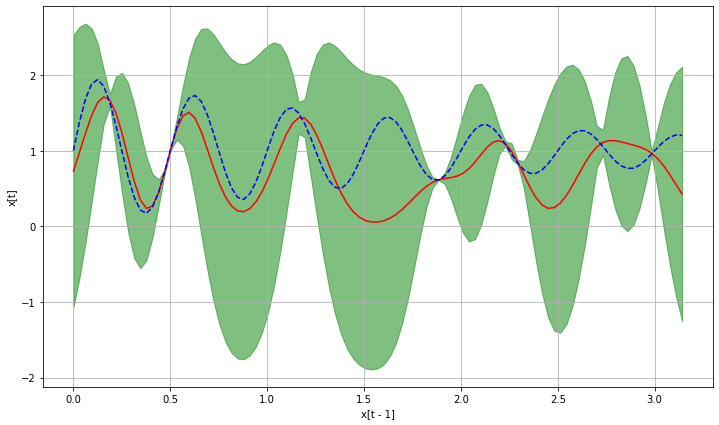

In [3]:
X = np.random.uniform(*bounds, (10, 1))
Y = transition(X)
model, pred_fun = train(X, Y)
_ = plot_pred(pred_fun, transition)

In [4]:
prev_point = np.array([[.25]])
cur_mu, cur_sigma = pred_fun(prev_point)
print(cur_mu, cur_sigma)

[[1.24316463]] [0.40209835]


In [5]:
# Propagate the uncertainty using the true function and sampling approximation
posterior = norm(cur_mu.ravel(), cur_sigma.ravel())
input_samples = posterior.rvs((2000, 1))
output_samples = transition(input_samples)

0.9977646926114375 0.3909119755090764


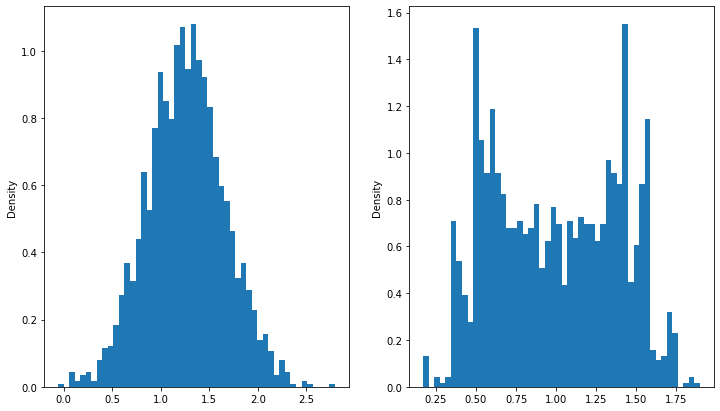

In [6]:
def histograms(*data, n_bins=50):
    fig, ax = plt.subplots(1, len(data), figsize=(12,7))
    for i, d in enumerate(data):
        ax[i].hist(d.ravel(), bins=n_bins, density=True)
        ax[i].set_ylabel("Density")
histograms(input_samples, output_samples)
next_mu_true = output_samples.mean()
next_sigma_true = output_samples.std(ddof=1)
print(next_mu_true, next_sigma_true)

0.8834713160948126 1.0697868671294513


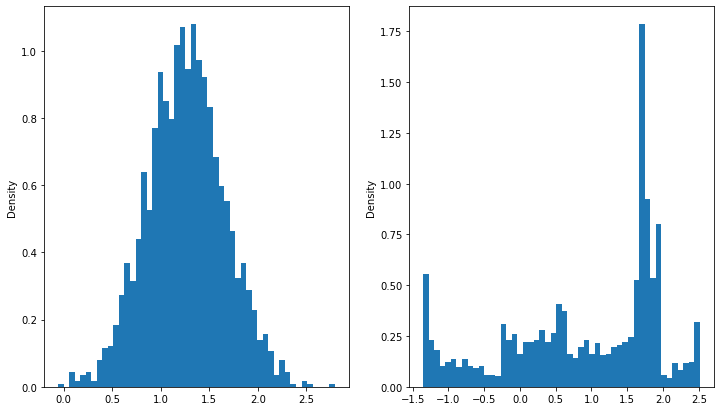

In [7]:
# Sampling from posterior for GP approximation
output_preds = model.sample_y(input_samples)
histograms(input_samples, output_preds)
next_mu_pred = output_preds.mean()
next_sigma_pred = output_preds.std(ddof=1)
print(next_mu_pred, next_sigma_pred)

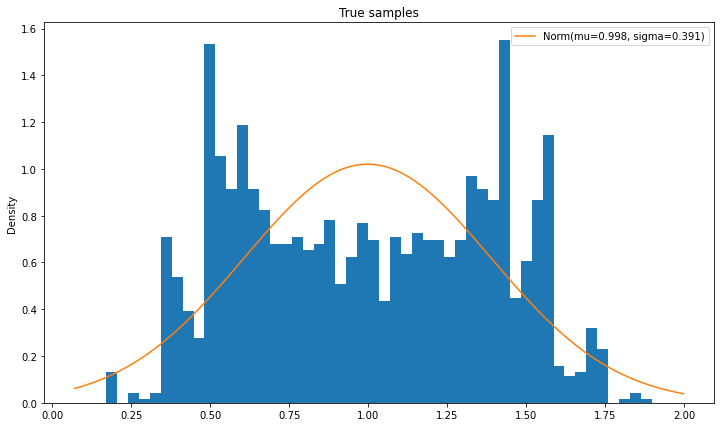

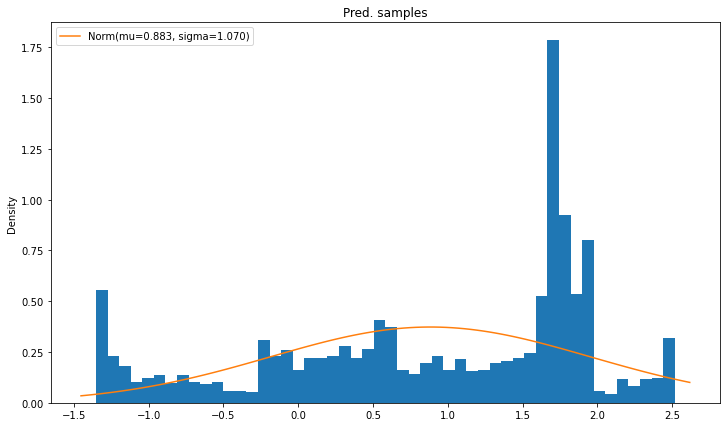

In [8]:
# Moment matching approximation
def compare_pdfs(data, pdf_funs, title, labels=None, n_bins=50):
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.hist(data.ravel(), bins=50, density=True)
    x_grid = np.linspace(data.min() - 0.1, data.max() + 0.1, 101, "Data")
    for i_fun, pdf_fun in enumerate(pdf_funs):
        if labels is None:
            label = "PDF " + str(i_fun + 1)
        else:
            label = labels[i_fun]
        ax.plot(x_grid, pdf_fun(x_grid), label=label)
    ax.set_ylabel("Density")
    ax.set_title(title)
    ax.legend()

def norm_label(mu, sigma):
    return f"Norm(mu={mu:.3f}, sigma={sigma:.3f})"

compare_pdfs(output_samples, [norm(next_mu_true, next_sigma_true).pdf], "True samples",
             labels=[norm_label(next_mu_true, next_sigma_true)])
compare_pdfs(output_preds, [norm(next_mu_pred, next_sigma_pred).pdf], "Pred. samples", 
            labels=[norm_label(next_mu_pred, next_sigma_pred)])

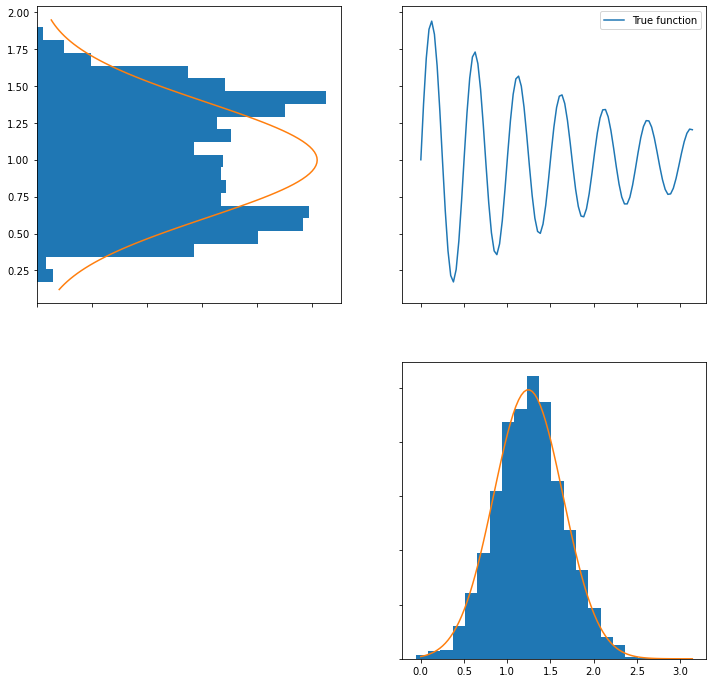

In [9]:
# Le big picture
def plot_big_picture_true(true_fun, samples, inp_pdf, n_bins=20):
    x_grid = np.linspace(*bounds, 101)
    y_true = true_fun(x_grid)
    out_samples = true_fun(samples)
    out_pdf = norm(out_samples.mean(), out_samples.std(ddof=1)).pdf
    fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharex="col", sharey="row")
    ax[0, 1].plot(x_grid, y_true, label="True function")
    ax[0, 1].legend()
    ax[1, 1].hist(samples, bins=n_bins, density=True)
    y_grid = np.linspace(out_samples.min() - 0.05, out_samples.max() + 0.05, 101)
    ax[1, 1].plot(x_grid, inp_pdf(x_grid).ravel())
    ax[0, 0].hist(out_samples, orientation="horizontal", bins=n_bins, density=True)
    ax[0, 0].plot(out_pdf(y_grid).ravel(), y_grid)
    ax[1, 0].axis("off")
plot_big_picture_true(transition, input_samples, norm(cur_mu, cur_sigma).pdf, )

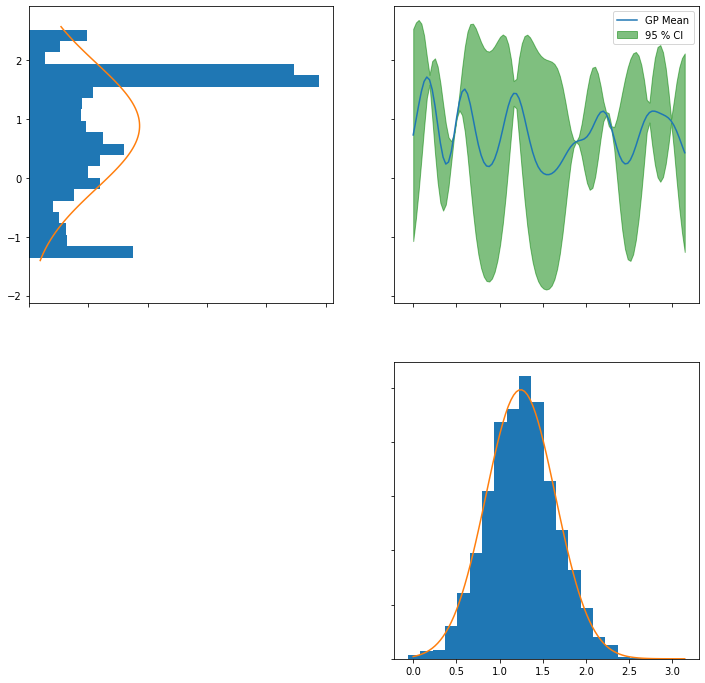

In [10]:
# Le big picture 2
def plot_big_picture_sample_pred(model, samples, inp_pdf, n_bins=20):
    x_grid = np.linspace(*bounds, 101)
    y_mu, y_sigma = model.predict(x_grid.reshape((-1, 1), ), return_std=True)
    y_mu, y_sigma = y_mu.ravel(), y_sigma.ravel()
    out_samples = model.sample_y(samples).ravel()
    out_pdf = norm(out_samples.mean(), out_samples.std(ddof=1)).pdf
    fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharex="col", sharey="row")
    ax[0, 1].fill_between(x_grid, y_mu + 1.96 * y_sigma, y_mu - 1.96 * y_sigma,
                          label="95 % CI", color="g", alpha=0.5)
    ax[0, 1].plot(x_grid, y_mu, label="GP Mean")
    ax[0, 1].legend()
    ax[1, 1].hist(samples, bins=n_bins, density=True)
    ax[1, 1].plot(x_grid, inp_pdf(x_grid).ravel())
    ax[0, 0].hist(out_samples, orientation="horizontal", bins=n_bins, density=True)
    y_grid = np.linspace(out_samples.min() - 0.05, out_samples.max() + 0.05, 101)
    ax[0, 0].plot(out_pdf(y_grid).ravel(), y_grid)
    ax[1, 0].axis("off")
plot_big_picture_sample_pred(model, input_samples, norm(cur_mu, cur_sigma).pdf, )

mu: 0.867533918054006 0.1590983263618532
sigma: 0.9769986099716209 1.18747063069897


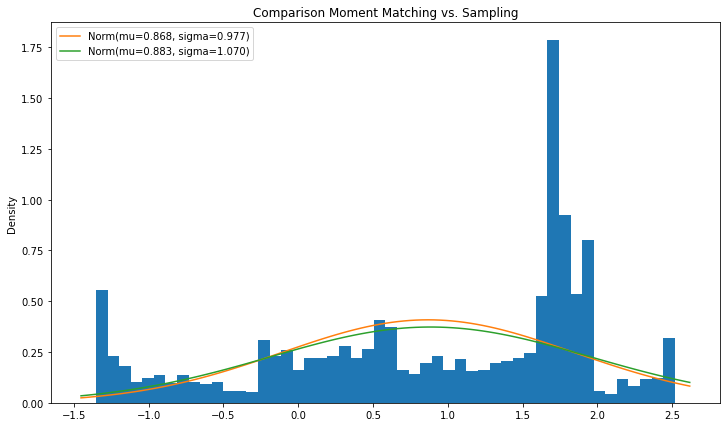

In [11]:
# Deisenroth et. al. Moment Matching using RBF for a single state dimension
# Original Eq. are much complicated as they have to regard state covariance

def moment_match_mu_next(model, mu_in, sigma_in):
    nus = model.X_train_ - mu_in # Eq. (16)
    ls_square = model.kernel_.length_scale # Eq. (6)
    var_in = sigma_in**2
    q_a = np.exp(-nus * (ls_square + var_in) ** -1  * nus) / (var_in * ls_square**-1 + 1) # Eq. (15)
    return np.sum(q_a * model.alpha_)

def moment_match_sigma_next(model, mu_in, sigma_in, mu_out):
    sigma_sq_out = sigma_in**2 + mu_in**2 - mu_out**2 # Eq. (17)
    return np.sqrt(sigma_sq_out).ravel()[0]

def moment_match(model, mu_in, sigma_in):
    mu_out = moment_match_mu_next(model, mu_in, sigma_in)
    sigma_out = moment_match_sigma_next(model, mu_in, sigma_in, mu_out)
    return mu_out, sigma_out

def sample_match(model, mu_in, sigma_in, samples=2000):
    samps = model.sample_y(norm(mu_in, sigma_in).rvs((samples, 1)))
    return samps.mean(), samps.std(ddof=1)


next_mu_sample, next_sigma_sample = sample_match(model, cur_mu, cur_sigma)
next_mu_mm, next_sigma_mm = moment_match(model, cur_mu, cur_sigma)

print("mu:", next_mu_mm, next_mu_sample)
print("sigma:", next_sigma_mm, next_sigma_sample)
compare_pdfs(output_preds, [norm(next_mu_mm, next_sigma_mm).pdf,
                            norm(next_mu_pred, next_sigma_pred).pdf], "Comparison Moment Matching vs. Sampling",
            labels=[norm_label(next_mu_mm, next_sigma_mm),
                    norm_label(next_mu_pred, next_sigma_pred)])



In [12]:
t0 = time()
mu_pred, sigma_pred = moment_match(model, cur_mu, cur_sigma)
print(f"Mu: {mu_pred:.3f} Sigma: {sigma_pred:.3f} Dura: {time() - t0:.6f} seconds")

Mu: 0.868 Sigma: 0.977 Dura: 0.000263 seconds


In [14]:

for samples in [2000, 1000, 500, 250, 100, 50, 25, 10, 5, 2]:
    t0 = time()
    mu_pred, sigma_pred = sample_match(model, cur_mu, cur_sigma, samples=samples)
    print(f"Samples: {samples:5d} Mu: {mu_pred:6.3f} Sigma: {sigma_pred:6.3f} Dura: {time() - t0:6.6f} seconds")

Samples:  2000 Mu:  0.924 Sigma:  1.069 Dura: 2.794175 seconds
Samples:  1000 Mu:  0.584 Sigma:  1.212 Dura: 0.133940 seconds
Samples:   500 Mu:  0.883 Sigma:  1.116 Dura: 0.024062 seconds
Samples:   250 Mu:  0.906 Sigma:  1.097 Dura: 0.006199 seconds
Samples:   100 Mu:  0.117 Sigma:  1.167 Dura: 0.001987 seconds
Samples:    50 Mu:  0.218 Sigma:  1.269 Dura: 0.001496 seconds
Samples:    25 Mu:  0.352 Sigma:  1.246 Dura: 0.044127 seconds
Samples:    10 Mu:  0.938 Sigma:  1.139 Dura: 0.001721 seconds
Samples:     5 Mu:  1.414 Sigma:  0.728 Dura: 0.001830 seconds
Samples:     2 Mu:  0.638 Sigma:  0.536 Dura: 0.001722 seconds


```{bibliography}
:filter: docname in docnames
:style: plain
```